Epoch [10/100], Loss: 0.0075
Epoch [20/100], Loss: 0.0055
Epoch [30/100], Loss: 0.0029
Epoch [40/100], Loss: 0.0025
Epoch [50/100], Loss: 0.0021
Epoch [60/100], Loss: 0.0019
Epoch [70/100], Loss: 0.0017
Epoch [80/100], Loss: 0.0015
Epoch [90/100], Loss: 0.0014
Epoch [100/100], Loss: 0.0012


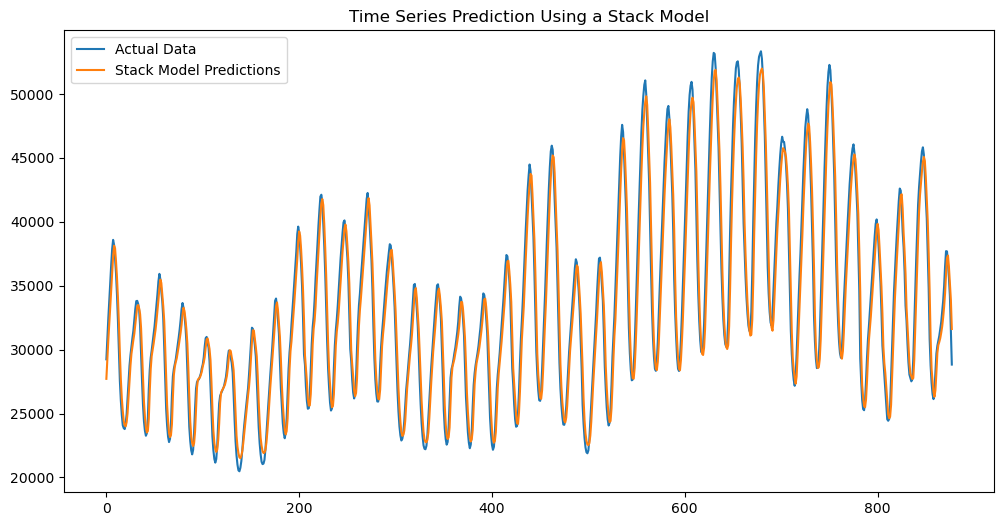

In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from torch.autograd import Variable
import matplotlib.pyplot as plt

# Load the imputed dataset
data = pd.read_csv('midatl_forecast_load_imputed.csv', index_col=0)

# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
data_normalized = scaler.fit_transform(data)

# Define a function to prepare data with look-back window
def create_dataset(dataset, look_back=3):
    X, Y = [], []
    for i in range(len(dataset) - look_back):
        a = dataset[i:(i + look_back), 0]
        X.append(a)
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

# Set look-back window
look_back = 3
X, y = create_dataset(data_normalized, look_back)

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Convert to PyTorch tensors
X_train = Variable(torch.Tensor(X_train))
X_test = Variable(torch.Tensor(X_test))
y_train = Variable(torch.Tensor(y_train))
y_test = Variable(torch.Tensor(y_test))

# Define the FNN Stack Model
class StackModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(StackModel, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Instantiate the model
input_size = look_back
hidden_size = 50
output_size = 1
stack_model = StackModel(input_size, hidden_size, output_size)

# Loss and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(stack_model.parameters(), lr=0.01)

# Training loop
epochs = 100
for epoch in range(epochs):
    stack_model.train()
    optimizer.zero_grad()
    outputs = stack_model(X_train)
    loss = criterion(outputs.squeeze(), y_train)
    loss.backward()
    optimizer.step()
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch + 1}/{epochs}], Loss: {loss.item():.4f}')

# Evaluate the model
stack_model.eval()
predictions = stack_model(X_test).detach().numpy()
y_test_actual = y_test.numpy()

# Denormalize predictions and actual values
predictions = scaler.inverse_transform(predictions.reshape(-1, 1))
y_test_actual = scaler.inverse_transform(y_test_actual.reshape(-1, 1))

# Plot results
plt.figure(figsize=(12, 6))
plt.plot(y_test_actual, label='Actual Data')
plt.plot(predictions, label='Stack Model Predictions')
plt.legend()
plt.title('Time Series Prediction Using a Stack Model')
plt.show()